In [1]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import numpy as np
import re
import neattext as nt
import neattext.functions as nfx
from neattext.explainer import emoji_explainer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
# I guess i need to plot for presentation in case.
import plotly.express as px
from pprint import pprint
import pyLDAvis.gensim
import pyLDAvis
import os
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as mplt


In [2]:
# Downloaded dataset from Kaggle https://www.kaggle.com/datasets/datasnaek/mbti-type
df = pd.read_csv('..\\data\\data\\mbti_1.csv')
df.head()

,type,posts
0,INFJ,'😂😂😂😂 http://www.youtube.com/watch?v=qsXHcwe3k...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
#drop all the na data. not gonna bother check.
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
# Check if all MBTI types are present . 4 *4 so must be total of 16
types = df['type'].unique()
print(types)
print(len(types))

['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']
16


In [5]:
# Check the distribution of the MBTI types in the dataset
print(df['type'].value_counts())
#plot the distribution of the MBTI types in the dataset
fig = px.bar(df['type'].value_counts(), title='Distribution of MBTI types in the dataset')

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


In [6]:
fig

Looks like INFP is more prominent in dataset. Anyway, clean the dataset

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['https','http','www'])
lemmatizer = nltk.WordNetLemmatizer()  
#Print the list of stopwords from nltk
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
#tokenize function to apply to dataframe
def cleantext (text):
    post = re.sub(r'\|\|\|',' ', text, flags=re.MULTILINE)
    post = gensim.utils.simple_preprocess(post, deacc=True)
    #remove links first
    post = re.sub(r'''http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+''', ' ', text, flags=re.MULTILINE)
    # removew all the numbers only too since it is useless.
    post = re.sub(r'''[0-9]+''', ' ', post, flags=re.MULTILINE)
    
    # remove all the punctuations
    post = re.sub(r'[^\w\s]',' ', post, flags=re.MULTILINE)
    # remove all the extra spaces
    post = re.sub(r'\s+',' ', post, flags=re.MULTILINE)
    # remove all the special characters 
    post = re.sub(r'[^\x00-\x7F]+',' ', post, flags=re.MULTILINE)
    # kaggle datasource says (Each entry separated by "|||" (3 pipe characters)) so we just remove it and process full chunk of text.
    # Maybe in advance, will have to consider processing each entry separately.
    # check if text contains emoji, if yes replace the emoji with the description
    
    
    #List of Emojis
    emoji_list = dict(zip(nt.explainer.__EMOJI_TO_NAME_DICT.values(), nt.explainer.__EMOJI_TO_NAME_DICT.keys()))
    for cr in post:
        if cr in emoji_list.keys():
            post = post.replace(cr, emoji_explainer(cr)+" ")
    # Lowercase the text
    
    post = post.lower()
    
    # Looking at Noise in the text Before cleaning
    # nt_text = nt.TextFrame(post)
    # print("Before - {}".format(  nt_text.noise_scan()))
    
    #Whatever left, trust the library and clean it 😂😂😂 and hope for the best for nows.
    #tokenize the text
    
    # Looking at Noise in the text After cleaning
    # nt_text = nt.TextFrame(post)
    # print("After - {}".format(  nt_text.noise_scan()))
    
    return post 
    
def tokenize_and_lemmatize_and_remove_stopwords(text):
    post = word_tokenize(text)
    #remove stopwords
    return [lemmatizer.lemmatize(p) for p in post if p not in stop_words]

In [9]:
# testing tokenization re working or not.
test = df['posts'][0]
print(test)
test = cleantext(test)
print(test) 
test = tokenize_and_lemmatize_and_remove_stopwords(test)
print(test)

'😂😂😂😂 http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg

In [10]:
df['clean_posts'] = df['posts'].apply(cleantext)
print(df['clean_posts'].head())

0     enfp and intj moments sportscenter not top te...
1     i m finding the lack of me in these posts ver...
2     good one _____ of course to which i say i kno...
3     dear intp i enjoyed our conversation the othe...
4     you re fired that s another silly misconcepti...
Name: clean_posts, dtype: object


In [11]:
df['tokens'] = df['clean_posts'].apply(tokenize_and_lemmatize_and_remove_stopwords)
print(df['tokens'].head())

0    [enfp, intj, moment, sportscenter, top, ten, p...
1    [finding, lack, post, alarming, sex, boring, p...
2    [good, one, _____, course, say, know, blessing...
3    [dear, intp, enjoyed, conversation, day, esote...
4    [fired, another, silly, misconception, approac...
Name: tokens, dtype: object


In [12]:
df_tokens = df['tokens'].apply(lambda x: ' '.join(x))
df_tokens.head()

0    enfp intj moment sportscenter top ten play pra...
1    finding lack post alarming sex boring position...
2    good one _____ course say know blessing curse ...
3    dear intp enjoyed conversation day esoteric ga...
4    fired another silly misconception approaching ...
Name: tokens, dtype: object

In [13]:
#Sentiment analysis for the dataset using Vader
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)

df['sentiment'] = df_tokens.apply(get_sentiment)
df = df.join(pd.DataFrame(df.pop('sentiment').values.tolist()))

In [14]:
#Convert the MBTI types to binary
# Extrovert Introvert
# Sensing Intuition
# Thinking Feeling
# Judging Perceiving
df['is_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['is_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['is_T'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['is_J'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

#Convert the MBTI types to binary individually in case needed.
df['E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['I'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df['S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['N'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df['T'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df['P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)



In [15]:
df.head()

,type,posts,clean_posts,tokens,neg,neu,pos,compound,is_E,is_S,is_T,is_J,E,I,S,N,T,F,J,P
0,INFJ,'😂😂😂😂 http://www.youtube.com/watch?v=qsXHcwe3k...,enfp and intj moments sportscenter not top te...,"[enfp, intj, moment, sportscenter, top, ten, p...",0.129,0.606,0.265,0.9924,0,0,0,1,0,1,0,1,0,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,i m finding the lack of me in these posts ver...,"[finding, lack, post, alarming, sex, boring, p...",0.117,0.604,0.279,0.9987,1,0,1,0,1,0,0,1,1,0,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one _____ of course to which i say i kno...,"[good, one, _____, course, say, know, blessing...",0.115,0.587,0.297,0.9985,0,0,1,0,0,1,0,1,1,0,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the othe...,"[dear, intp, enjoyed, conversation, day, esote...",0.086,0.666,0.248,0.9985,0,0,1,1,0,1,0,1,1,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,you re fired that s another silly misconcepti...,"[fired, another, silly, misconception, approac...",0.185,0.541,0.274,0.9930,1,0,1,1,1,0,0,1,1,0,1,0


In [16]:
#plot the distribution of the MBTI types in the dataset
# print(pd.melt(df[['is_E', 'is_S', 'is_T', 'is_J']]).value_counts())
mbti_df = df[['E', 'I', 'S', 'N', 'T', 'F', 'J', 'P']]
value_counts_df = mbti_df.sum().reset_index()
print(value_counts_df)
#plot the graph
fig = px.bar(value_counts_df, x='index', y=0, title='Distribution of MBTI types in the dataset')
fig.show()

  index     0
0     E  1999
1     I  6676
2     S  1197
3     N  7478
4     T  3981
5     F  4694
6     J  3434
7     P  5241


*This is the Section to start To see if Word Counts and type of the words (Nouns, Adjs, Advs) Matters*

In [17]:
#Word Count
df['word_per_comment'] = df['posts'].apply(lambda x: len(x.split())) ## Dont know should use the clean_posts or not.
df['avg_word_per_comment'] = df['word_per_comment'] / 50 # Coz 50 Posts Per Data Row Seperated by |||

#function to classify the count  of words type using nltk.post_tag
nltk_tagset = ['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']
def count_tags(text):
    #Create Dictionary to store the count of each tag
    nltk_tags_count = {tag:0 for tag in nltk_tagset}
    tags = nltk.pos_tag(text)
    for tag in tags:
        # Later+
        pass
    return 1

In [18]:
#TF_IDF 
from sklearn.feature_extraction.text import  TfidfVectorizer
vectorizer =TfidfVectorizer(analyzer="word", ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_posts'].values)

In [19]:
id2word = corpora.Dictionary(df['tokens'])
texts = df['tokens']
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 3), (11, 1), (12, 2), (13, 7), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 4), (81, 1), (82, 2), (83, 3), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [20]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=7)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"like" + 0.012*"people" + 0.009*"think" + 0.008*"one" + 0.008*"know" '
  '+ 0.007*"really" + 0.007*"get" + 0.007*"time" + 0.006*"would" + '
  '0.006*"thing"'),
 (1,
  '0.014*"like" + 0.011*"think" + 0.009*"people" + 0.008*"one" + 0.008*"get" + '
  '0.008*"would" + 0.007*"thing" + 0.006*"time" + 0.006*"know" + '
  '0.005*"really"'),
 (2,
  '0.010*"like" + 0.009*"think" + 0.008*"really" + 0.008*"people" + '
  '0.007*"one" + 0.007*"thing" + 0.006*"know" + 0.006*"time" + 0.005*"get" + '
  '0.005*"would"'),
 (3,
  '0.013*"like" + 0.011*"think" + 0.009*"know" + 0.008*"people" + 0.008*"time" '
  '+ 0.007*"really" + 0.006*"one" + 0.006*"would" + 0.006*"get" + '
  '0.005*"thing"'),
 (4,
  '0.014*"like" + 0.008*"know" + 0.008*"people" + 0.008*"think" + 0.008*"one" '
  '+ 0.007*"thing" + 0.007*"really" + 0.007*"time" + 0.007*"would" + '
  '0.006*"feel"'),
 (5,
  '0.013*"like" + 0.009*"think" + 0.008*"people" + 0.007*"one" + 0.007*"know" '
  '+ 0.007*"thing" + 0.006*"would" + 0.006*"

In [21]:

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(7))
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003597 -0.000155       1        1  28.582443
1     -0.001768  0.003038       2        1  24.014787
3     -0.001111 -0.002412       3        1  15.903856
5      0.000175 -0.001368       4        1  10.938818
4      0.000806  0.000169       5        1   8.472496
2      0.002668 -0.001120       6        1   8.191654
6      0.002827  0.001848       7        1   3.895946, topic_info=          Term          Freq         Total Category  logprob  loglift
118       like  71641.000000  71641.000000  Default  30.0000  30.0000
153     people  48536.000000  48536.000000  Default  29.0000  29.0000
409       know  37640.000000  37640.000000  Default  28.0000  28.0000
213      think  51116.000000  51116.000000  Default  27.0000  27.0000
170     really  34623.000000  34623.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
117       life    598.090503  16338.423937   Topic7  -5.8344  -0.0623
260       also    620.546808  18082.413318   Topic7  -5.7975  -0.1269
197  something    631.172698  19610.577267   Topic7  -5.7805  -0.1910
78      friend    628.360584  22181.174323   Topic7  -5.7850  -0.3187
184        see    603.048988  19554.432208   Topic7  -5.8261  -0.2337

[625 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
78882      3  0.531634  ________________________
39296      1  0.478481                      __fp
588        1  0.330955                  actually
588        2  0.212757                  actually
588        3  0.128985                  actually
...      ...       ...                       ...
801        7  0.037600                       yes
29374      1  0.656162                  youuuuuu
49736      1  0.243434                 zentangle
49736      2  0.243434                 zentangle
49736      3  0.486868                 zentangle

[1521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 5, 3, 7])

In [22]:
# Doing Agglomerative Clustering 


pca = PCA(n_components=2)  # Reduce to 2 dimensions
svd = TruncatedSVD(n_components=2)  # Reduce to 2 dimensions
X_reduced_pca = pca.fit_transform(X)
X_reduced_svd = svd.fit_transform(X)
clustering = AgglomerativeClustering(n_clusters=3) 

In [28]:
# Step 4: Perform agglomerative clustering
clustering_pca = clustering.fit(X_reduced_pca)
clustering_svd = clustering.fit(X_reduced_svd)
# Step 5: Visualize the clusters
# This step is optional and can be complex with large datasets or high number of clusters
# Here's a simple example with a dendrogram


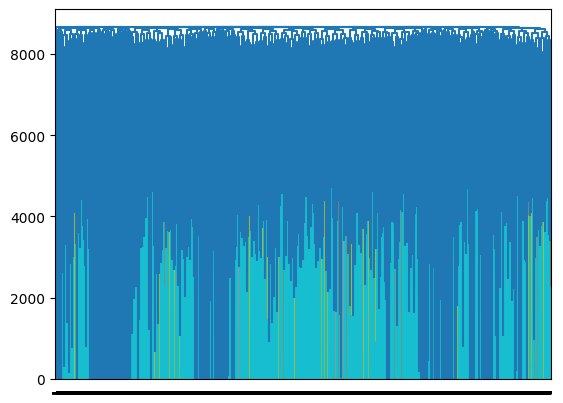

In [26]:
#PCA
children = clustering_pca.children_
distance = np.arange(children.shape[0])
no_of_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
dendrogram(linkage_matrix, labels=clustering.labels_)
mplt.show()

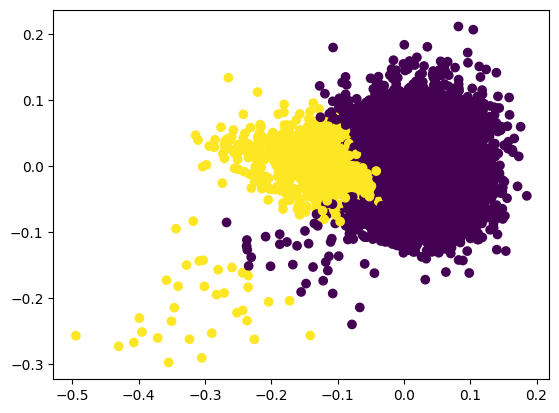

In [30]:
mplt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=clustering_pca.labels_)
mplt.show()

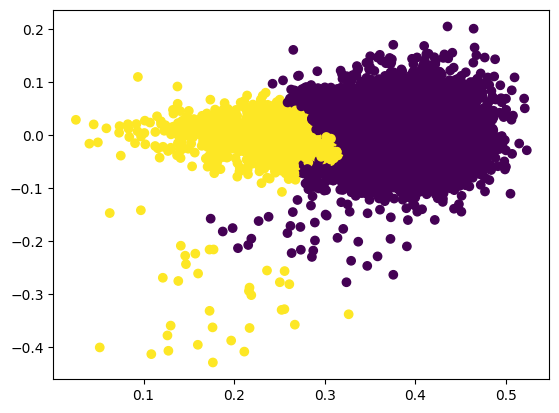

In [31]:
mplt.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=clustering_svd.labels_)
mplt.show()

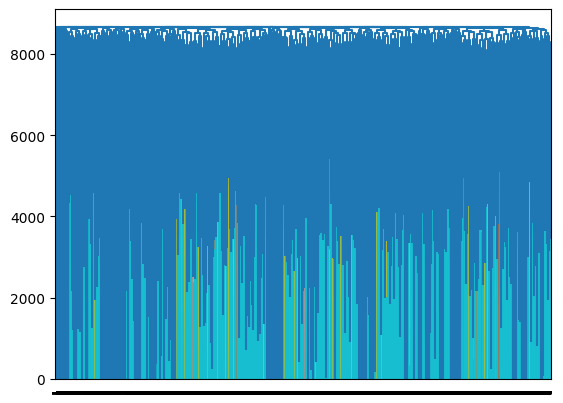

In [27]:
#SVD
children = clustering_svd.children_
distance = np.arange(children.shape[0])
no_of_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
dendrogram(linkage_matrix, labels=clustering.labels_)
mplt.show()